<a href="https://www.kaggle.com/code/adrienmorel97/eda-xgboost-optuna-39-10550?scriptVersionId=221390943" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🚀 Kaggle Playground Series: Predicting Backpack Prices

Welcome to the **Kaggle Playground Series**! In this notebook, we’ll guide you through the exciting world of **data preprocessing** and **feature engineering** to get our dataset ready for powerful machine learning models.

🎯 **Objective**: Predict the **price** of backpacks based on various attributes!

We'll kick things off by **imputing missing values** for both categorical and numerical features, ensuring a clean dataset. Then, we’ll apply **target encoding** to capture relationships between **categorical variables** and the target price. Finally, we’ll standardize numerical features to bring everything to a uniform scale for optimal model performance.

💡 By the end of this process, you’ll have a well-prepared dataset ready to tackle **regression models** and minimize the **RMSE** (Root Mean Squared Error) score.

Let’s jump right into the action and prepare our data for a top-tier model! 🚀


# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a critical step in any data project. It allows us to understand, summarize, and visualize the dataset effectively, paving the way for further analysis or modeling.

---

### Objectives

- 🕵️‍♀️ Gain insights into the data.
- 📊 Visualize distributions, relationships, and patterns.
- 🧹 Identify missing values, outliers, and data inconsistencies.etection.

---

Let’s dive into the EDA! 🚀

## Dataset Overview

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import time
import warnings

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans
from sklearn.ensemble import StackingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

# ML Models
from xgboost import XGBRegressor
import lightgbm as lgb

# Target Encoding
from cuml.preprocessing import TargetEncoder

# Hyperparameter Tuning
import optuna

# Progress Bar
from tqdm.auto import tqdm

# Suppress unnecessary warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

In [3]:
train_df=pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
test_df=pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')
train_extra = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv", index_col='id')
train_df = pd.concat([train_df, train_extra], axis=0, ignore_index=True)

In [4]:
# Check dataset shape and first rows
print(f"Dataset contains {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
train_df.head()

Dataset contains 3994318 rows and 11 columns.


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0.0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1.0,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2.0,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3.0,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4.0,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


- **Dataset Scope**  
  With **300,000 rows**, this is a **large dataset** by most retail analytics standards. It allows robust statistical analyses, but also demands efficient handling (e.g., distributed processing or optimized sampling) to manage memory and runtime.

- **Brand & Pricing Strategy**  
  Multiple brands indicate potential brand-based pricing differences. Identifying which brands (e.g., Nike, Adidas) command higher prices can refine pricing policy and margin optimization.

- **Product Differentiation**  
  Features like laptop compartments, waterproofing, and the number of compartments likely drive price variance. Pinpointing each feature’s contribution helps tailor product development and marketing messages.

- **Feature Correlation**  
  Relationship analysis (e.g., material vs. price, size vs. weight capacity) can uncover distinct product tiers (premium vs. budget) and guide inventory decisions.

- **Segmentation & Targeting**  
  Different styles (Tote, Messenger) and sizes (Small, Medium) suggest product segmentation. Coupled with brand and feature data, these segments can inform targeted promotions and merchandising.


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    float64
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(4), object(7)
memory usage: 335.2+ MB


- **Missing Data**  
  - Several columns (e.g., Brand, Material, Laptop Compartment) have non-null counts slightly below 300,000.  
  - This suggests missing values in these categorical fields, though the amount (up to a few thousand missing) seems relatively small in percentage terms.  

- **Implications**  
  - **Data Cleaning**: We’ll likely need to decide whether to impute, fill, or drop these missing values, especially in key columns (Brand, Material).  
  - **Feature Engineering**: Converting object columns to categorical (where appropriate) can improve efficiency and model performance.  
  - **Further Exploration**: Understanding why certain fields are missing may reveal data entry issues or optional attributes (e.g., some brands/materials might be unknown).  

In [6]:
# Save 'id' column from the test set for submission
test_ids = test_df['id'].copy()

# Drop 'id' column from train and test if present
if 'id' in train_df.columns:
    train_df.drop('id', axis=1, inplace=True)
if 'id' in test_df.columns:
    test_df.drop('id', axis=1, inplace=True)

# Define the target column
target_column = 'Price'

# Identify categorical and numerical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
numerical_columns = train_df.select_dtypes(exclude=['object']).columns

# Print out column information for verification
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: Price

Categorical Columns: ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

Numerical Columns: ['Compartments', 'Weight Capacity (kg)', 'Price']


## Descriptive Statistics

In [7]:
train_df.describe().round(2)

,Compartments,Weight Capacity (kg),Price
count,3994318.00,3992510.00,3994318.00
mean,5.43,18.01,81.36
std,2.89,6.97,38.94
min,1.00,5.00,15.00
25%,3.00,12.07,47.47
50%,5.00,18.05,80.98
75%,8.00,23.99,114.86
max,10.00,30.00,150.00


- **Compartments**  
  - Range: 1 to 10 (min to max), mean ≈ 5.44, median = 5.  
  - Balanced distribution around 5 compartments—most bags have between 3 and 8 compartments.

- **Weight Capacity (kg)**  
  - Range: 5 to 30, mean ≈ 18.03, median ≈ 18.07.  
  - Narrow standard deviation (≈ 7), suggesting most bags cluster in the 12–24 kg range.  
  - Slightly fewer non-null values (299,862) indicate missing data in some rows.

- **Price**  
  - Range: \$15 to \$150, mean ≈ \$81.41, median ≈ \$80.96.  
  - Standard deviation ≈ \$39, reflecting a broad price spread.  
  - Lower quartile at \$47.38 vs. upper quartile at \$115.02 points to distinct low-/mid-/high-price segments.

- **Overall**  
  - Numeric columns appear well-distributed.  
  - Price shows significant variability, suggesting potential for segmentation (e.g., budget vs. premium bags).  

- **Next Steps**  
  - Explore correlations (e.g., Compartments vs. Price, Weight Capacity vs. Price).

In [8]:
for column in categorical_columns:
    num_unique = train_df[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'Brand' has 5 unique categories.
'Material' has 4 unique categories.
'Size' has 3 unique categories.
'Laptop Compartment' has 2 unique categories.
'Waterproof' has 2 unique categories.
'Style' has 3 unique categories.
'Color' has 6 unique categories.


In [9]:
# Print unique value counts for each categorical column
for column in categorical_columns:
    print(f"\nTop value counts in '{column}':\n{train_df[column].value_counts().head(10)}")


Top value counts in 'Brand':
Brand
Under Armour    801035
Adidas          797000
Nike            764407
Puma            755778
Jansport        749340
Name: count, dtype: int64

Top value counts in 'Material':
Material
Polyester    1060882
Leather       976186
Nylon         942656
Canvas        903632
Name: count, dtype: int64

Top value counts in 'Size':
Size
Medium    1354487
Large     1312295
Small     1239751
Name: count, dtype: int64

Top value counts in 'Laptop Compartment':
Laptop Compartment
Yes    1972937
No     1922848
Name: count, dtype: int64

Top value counts in 'Waterproof':
Waterproof
Yes    1969205
No     1930789
Name: count, dtype: int64

Top value counts in 'Style':
Style
Messenger    1329677
Tote         1297942
Backpack     1262519
Name: count, dtype: int64

Top value counts in 'Color':
Color
Pink     688257
Gray     666110
Blue     638485
Red      630215
Black    620610
Green    617024
Name: count, dtype: int64


1. **Brand Distribution**  
  - Top 5 brands—Adidas, Under Armour, Nike, Puma, Jansport—each hover around 56–60k entries. This fairly even split suggests no single brand dominates. Any price or sales strategies might hinge on subtle differences between them.

2. **Material Preferences**  
  - Polyester (79k) leads, followed by Leather (73k), Nylon (71k), and Canvas (68k). The mix implies different market segments (premium leather vs. lightweight polyester). Analyzing price or reviews by material may reveal performance or cost differentials.

3. **Size Breakdown**  
  - Medium (102k), Large (99k), Small (93k) are all well-represented. Customers likely see value in all three size categories. Cross-referencing size with price or compartments could uncover interesting product niches (e.g., premium large-capacity bags).

4. **Laptop Compartment & Waterproof**  
  - Both yes/no columns are nearly balanced (~148k yes vs. ~144k no). This balance hints at two broad segments: more feature-rich vs. simpler designs. Examining whether these features correlate with higher prices or specific brands could be insightful.

5. **Style**  
  - Messenger (100k), Tote (97k), and Backpack (95k) are fairly evenly distributed, reinforcing the notion of multiple core style preferences in this market. Each style might align with different target demographics or usage scenarios.

6. **Color Trends**  
  - Pink tops the list with ~52k, followed by Gray (~50k), Blue (~48k), Red (~47k), Green (~46k), and Black (~46k). Surprisingly, Pink and Gray outrank classic colors like Black. A deeper dive into price segments by color could confirm whether these colors are associated with specific brands or premium lines.

**Key Takeaways**  
1. **Balanced Feature Distributions**: Nearly every categorical feature is split in a way that suggests strong variety, meaning we can segment by brand, material, size, etc.  
2. **Feature Interactions**: Next steps involve cross-tabulating these columns (e.g., brand + material + size) to see if certain combinations carry a price premium.  
3. **Potential for Segmentation**: The presence of multiple styles, color preferences, and feature sets indicates strong segmentation potential, guiding targeted product strategies or marketing.


## Data Cleaning Insights

In [10]:
# Calculate the percentage of rows containing at least one NaN
nan_rows_percentage = round(train_df.isna().any(axis=1).mean() * 100, 2)
print(f"Percentage of rows with at least one NaN: {nan_rows_percentage}%")

Percentage of rows with at least one NaN: 17.67%


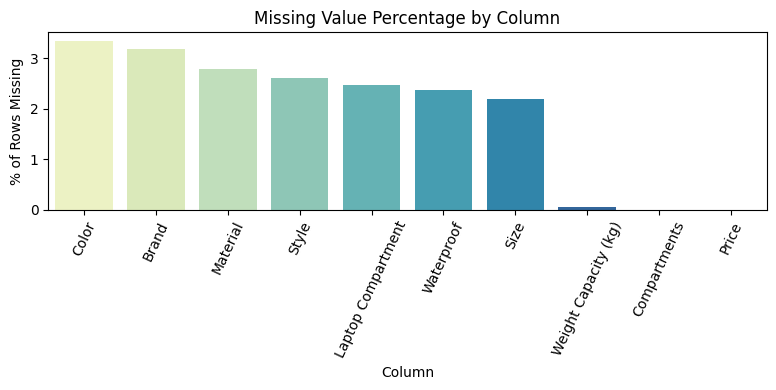

In [11]:
# Calculate missing percentages
missing_percentages = (train_df.isnull().sum() / len(train_df)) * 100

# Convert to a DataFrame for convenience
df_miss = (
    pd.DataFrame({
        "Column": missing_percentages.index,
        "MissingPct": missing_percentages.values
    })
    .sort_values("MissingPct", ascending=False)  # Optional: sort by descending % 
    .reset_index(drop=True)
)

# Create a discrete color palette from magma
colors = sns.color_palette("YlGnBu", len(df_miss))

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=df_miss, x="Column", y="MissingPct", palette=colors)
plt.title("Missing Value Percentage by Column")
plt.ylabel("% of Rows Missing")
plt.xticks(rotation=65)
plt.tight_layout()
plt.show()


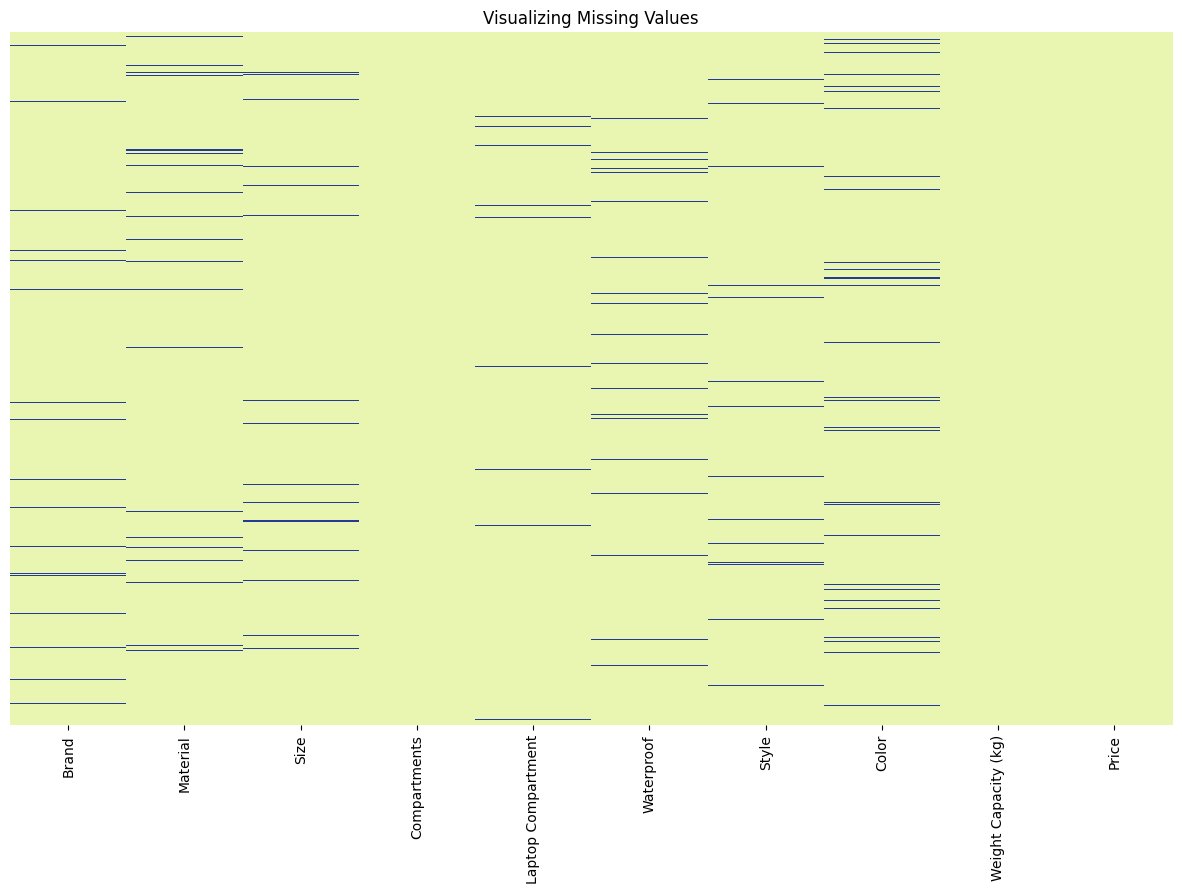

In [12]:
plt.figure(figsize=(15,9))
plt.title("Visualizing Missing Values")
sns.heatmap(train_df.isnull(), cbar=False, cmap=sns.color_palette('YlGnBu'), yticklabels=False);
plt.show()

- **Overall Pattern**  
  From the heatmap, missing values are dispersed across all columns.

- **Most-Affected Columns**  
  - **Brand, Material, Waterproof, Style, Color** each show intermittent missing entries. 
  - **Weight Capacity (kg)** also has occasional gaps, though visually less frequent.

- **No Large Blocks of Missing Data**  
  The missing stripes don’t cluster heavily in any single region, suggesting there’s no massive block of rows missing most fields—this implies the data is partially complete in a scattered fashion.

- **Potential Causes**  
  - **Optional Fields**: Some attributes might be optional during data entry, leading to sporadic nulls (e.g., certain brands or models not specifying material or waterproof info).  
  - **Data Source Variation**: Different data suppliers could omit certain features.

## Visual Exploration

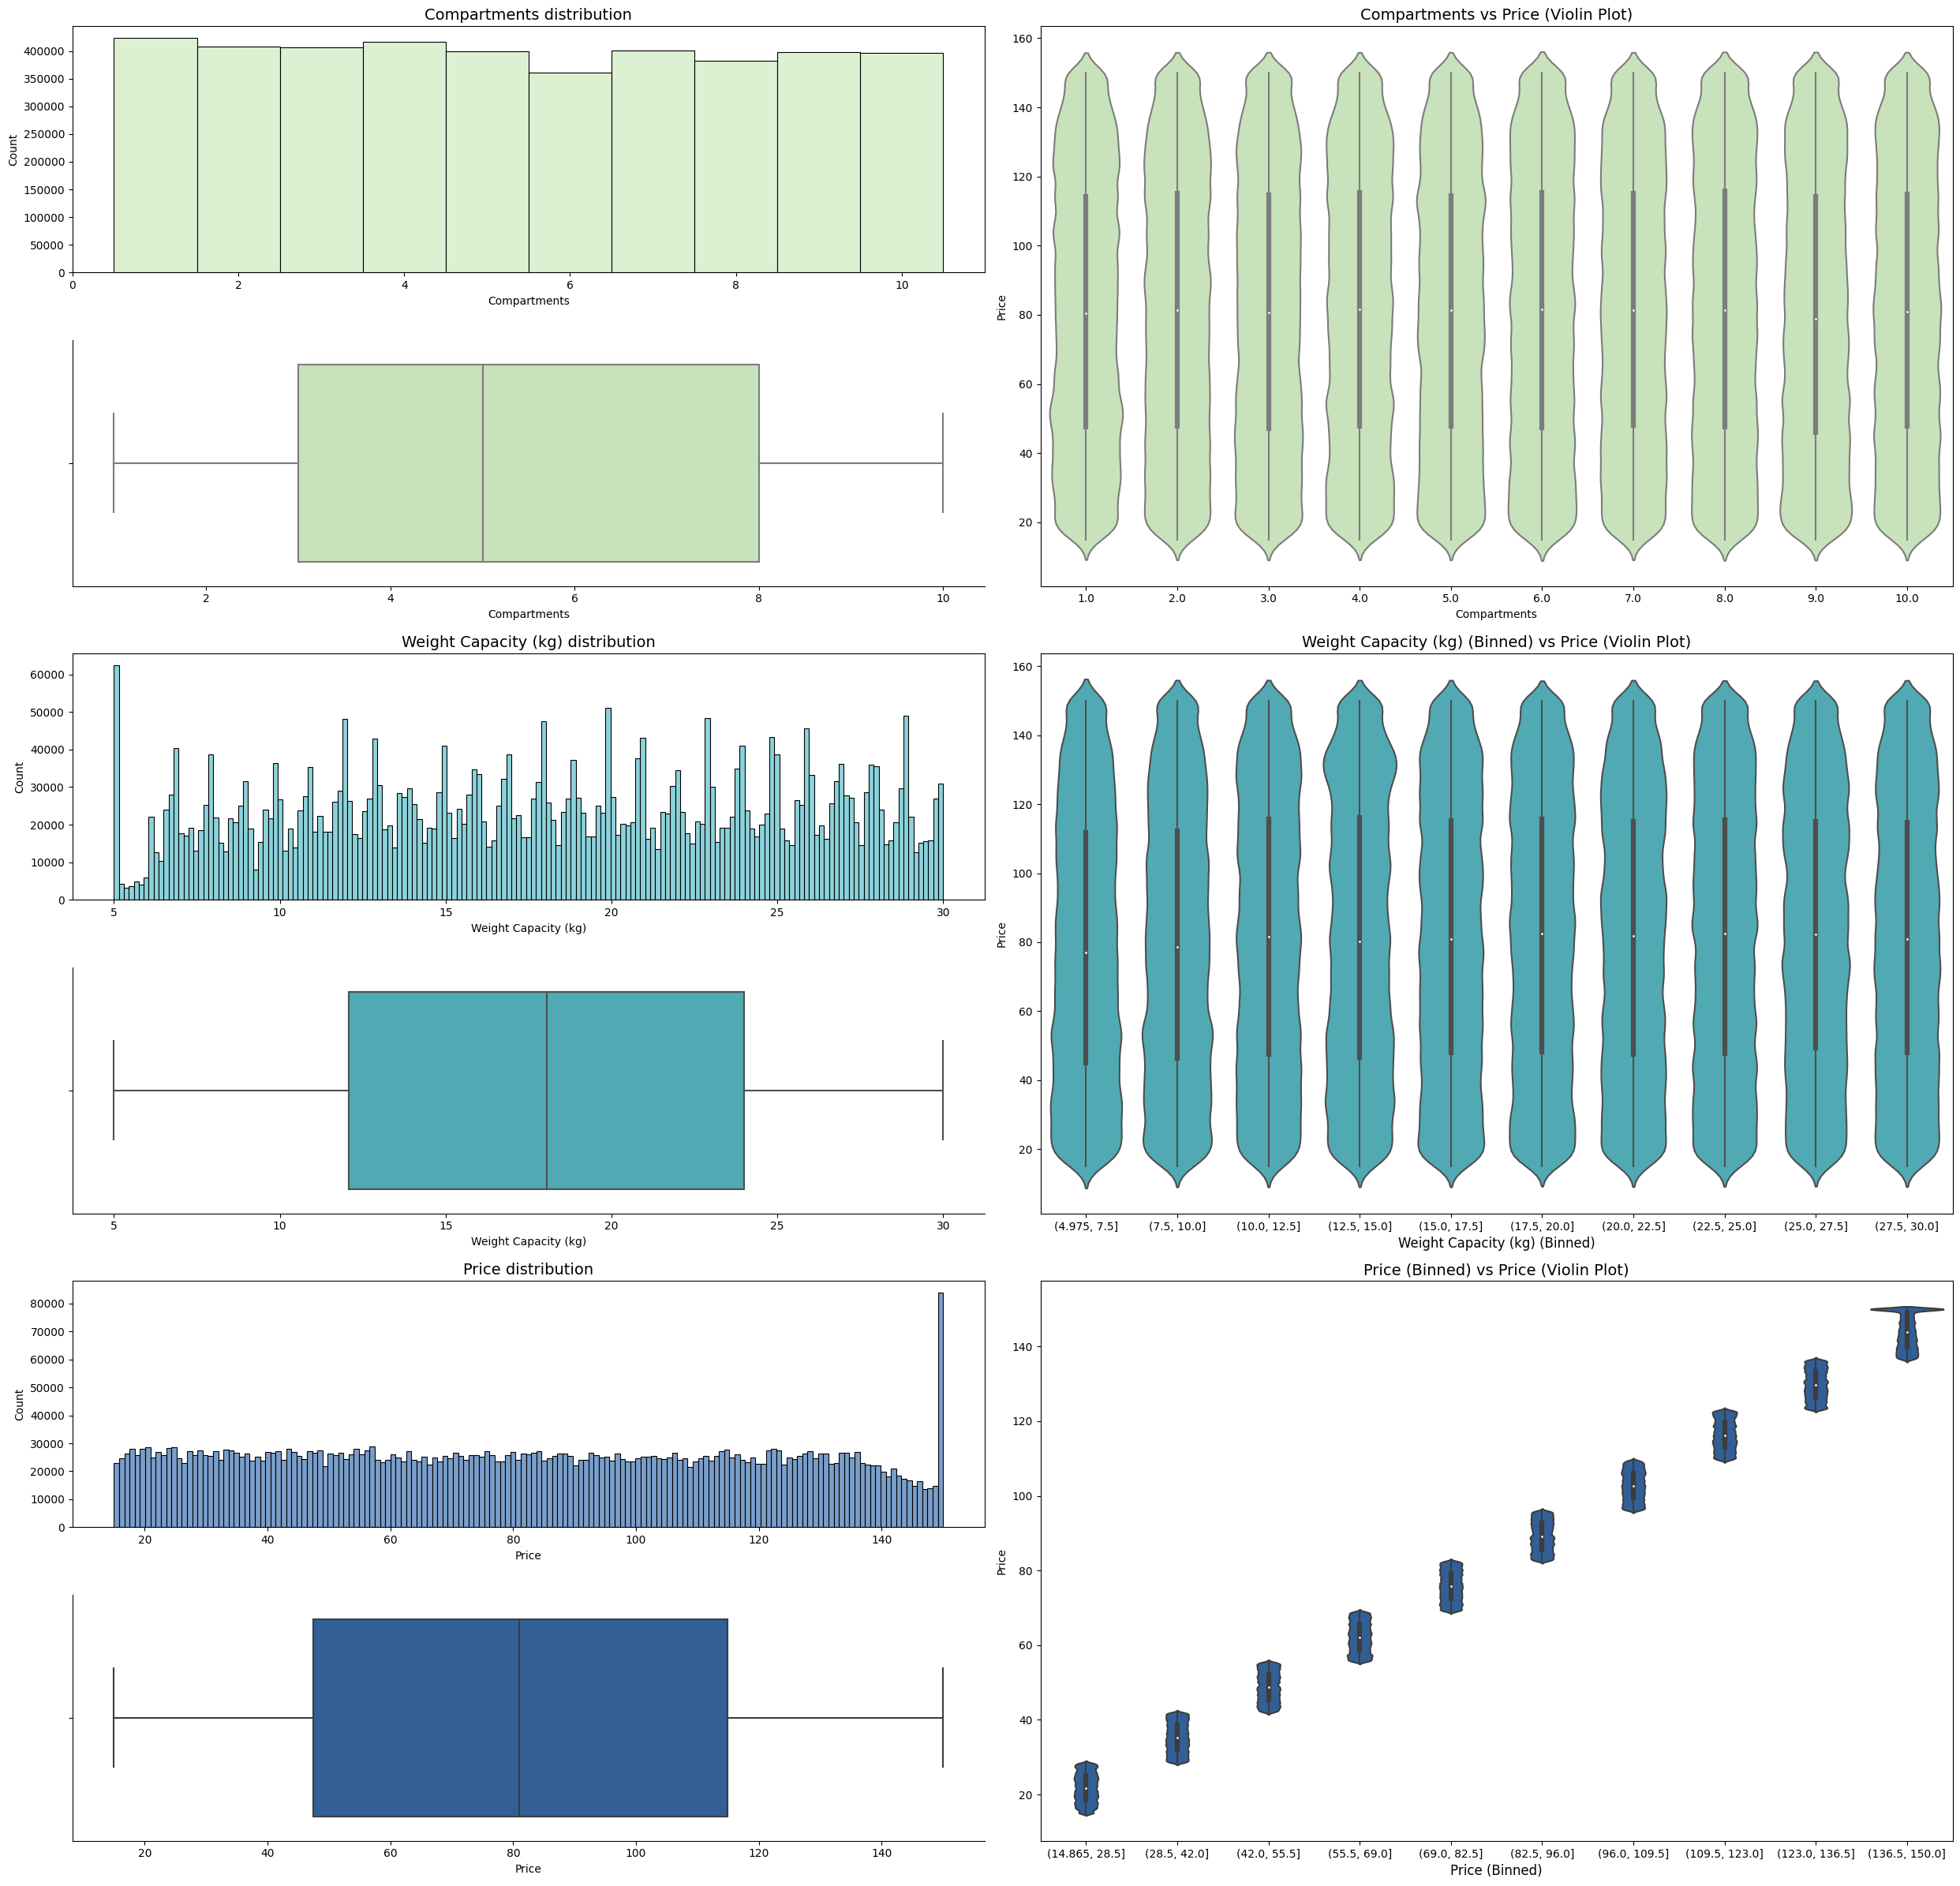

In [13]:
# Create a color palette for the columns
palette = sns.color_palette('YlGnBu', len(numerical_columns))
color_dict = dict(zip(numerical_columns, palette))

# Create a grid of subplots for histograms, boxplots, and scatterplots/violin plots
fig = plt.figure(figsize=(25, 8 * len(numerical_columns)))
gs = gridspec.GridSpec(2 * len(numerical_columns), 2, figure=fig)

df_binned = train_df.copy()

for i, column in enumerate(numerical_columns):

    if train_df[column].nunique() > 50: discrete = False
    else : discrete = True
    
    # Plot histogram with a unique color
    ax_hist = fig.add_subplot(gs[2 * i, 0])
    sns.histplot(
        data=train_df, x=column, fill=True, common_norm=False, alpha=0.6,
        linewidth=0.8, color=color_dict[column], ax=ax_hist,  discrete = discrete
    )
    ax_hist.set_title(f'{column} distribution', fontsize=14)

    
    # Plot boxplot with the same unique color
    ax_box = fig.add_subplot(gs[2 * i + 1, 0])
    sns.boxplot(data=train_df, x=column, ax=ax_box, color=color_dict[column])
    sns.despine(ax=ax_box)

    # Conditional plot: violin plot or barplot based on unique values, fallback to scatterplot
    ax_conditional = fig.add_subplot(gs[2 * i:2 * i + 2, 1])  # Merges 2 rows
    if train_df[column].nunique() <= 10:
        # If the column has 10 or fewer unique values, use a violin plot
        sns.violinplot(data=train_df, x=column, y=target_column, ax=ax_conditional, color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} vs {target_column} (Violin Plot)', fontsize=14)
    else:
        # Bin the column into 10 intervals, but keep original target column values
        df_binned['Binned Column'] = pd.cut(train_df[column], bins=10)
        sns.violinplot(data=df_binned, x='Binned Column', y=target_column, ax=ax_conditional, color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} (Binned) vs {target_column} (Violin Plot)', fontsize=14)
        ax_conditional.set_xlabel(f'{column} (Binned)', fontsize=12)

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

### Combined Insights

1. **Compartments :**
- **Bar Chart**: The dataset includes 0, 2, 4, 6, 8, and 10 compartments with fairly even counts—no single compartment number dominates.  
- **Boxplot**: Ranges from **0** (min) to **10** (max). The middle 50% of bags lie between 2 and 8 compartments, with a **median** around 5.  
- **Violin Plot**: Confirms a broad but balanced spread from 0 to 10 compartments, clustering most heavily near the midrange (~5).

2. **Weight Capacity (kg) :**
- **Distribution**: Spans **5–30 kg**, with moderate peaks near 10, 15, and 25 kg.  
- **Boxplot**: Q1 ≈ 10 kg, Q3 ≈ 25 kg, median ~15–17 kg, indicating most bags cluster in the mid-capacity range.  
- **Violin Plot**: Binning capacity into intervals shows similar price ranges (15 to 150) in each bin—no strong link between capacity and higher/lower price.

3. **Price :**
- **Histogram**: Prices spread from **15** to **150**, relatively uniform except for a notable spike near 150, hinting at a premium segment.  
- **Boxplot**: The interquartile range is ~40–110, with a median near 80. Whiskers confirm legitimate low- and high-end products.  
- **Violin Plot**: Binned price intervals each center on their midpoint, culminating in a denser luxury tier at the top bin (136.5–150).

**Overall Conclusion :** 
- **Compartments** and **Weight Capacity** show broad, balanced distributions but do **not** strongly influence pricing.  
- **Price** exhibits a wide spectrum, from budget (~15) to premium (~150), likely driven by other features (e.g., brand, material).

## Correlation Analysis  

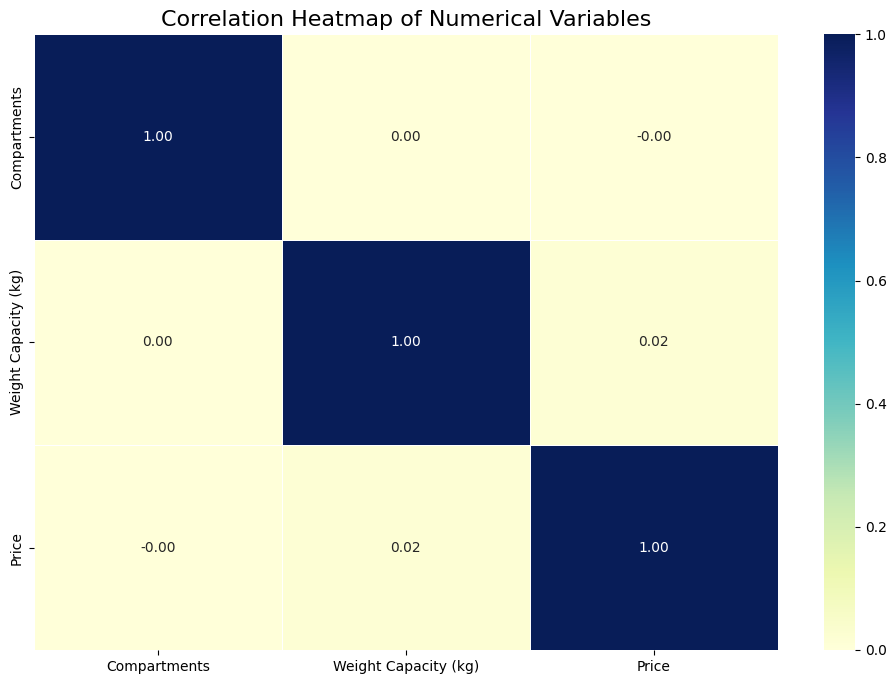

In [14]:
# Calculate the correlation matrix
correlation_matrix = train_df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()



- **No meaningful correlation** between **Compartments**, **Weight Capacity**, and **Price** (all values ~0).  
- **Weight Capacity vs. Price (0.02)**: Essentially no relationship—heavier bags are not systematically more expensive.  
- **Compartments vs. Price (-0.00)**: Zero correlation, confirming that the number of compartments does not drive pricing.  

🔍 **Conclusion**: Structural features like compartments and weight do **not** impact price—other factors (e.g., brand, material) likely explain price variations.


## Categorical Features & Price Analysis

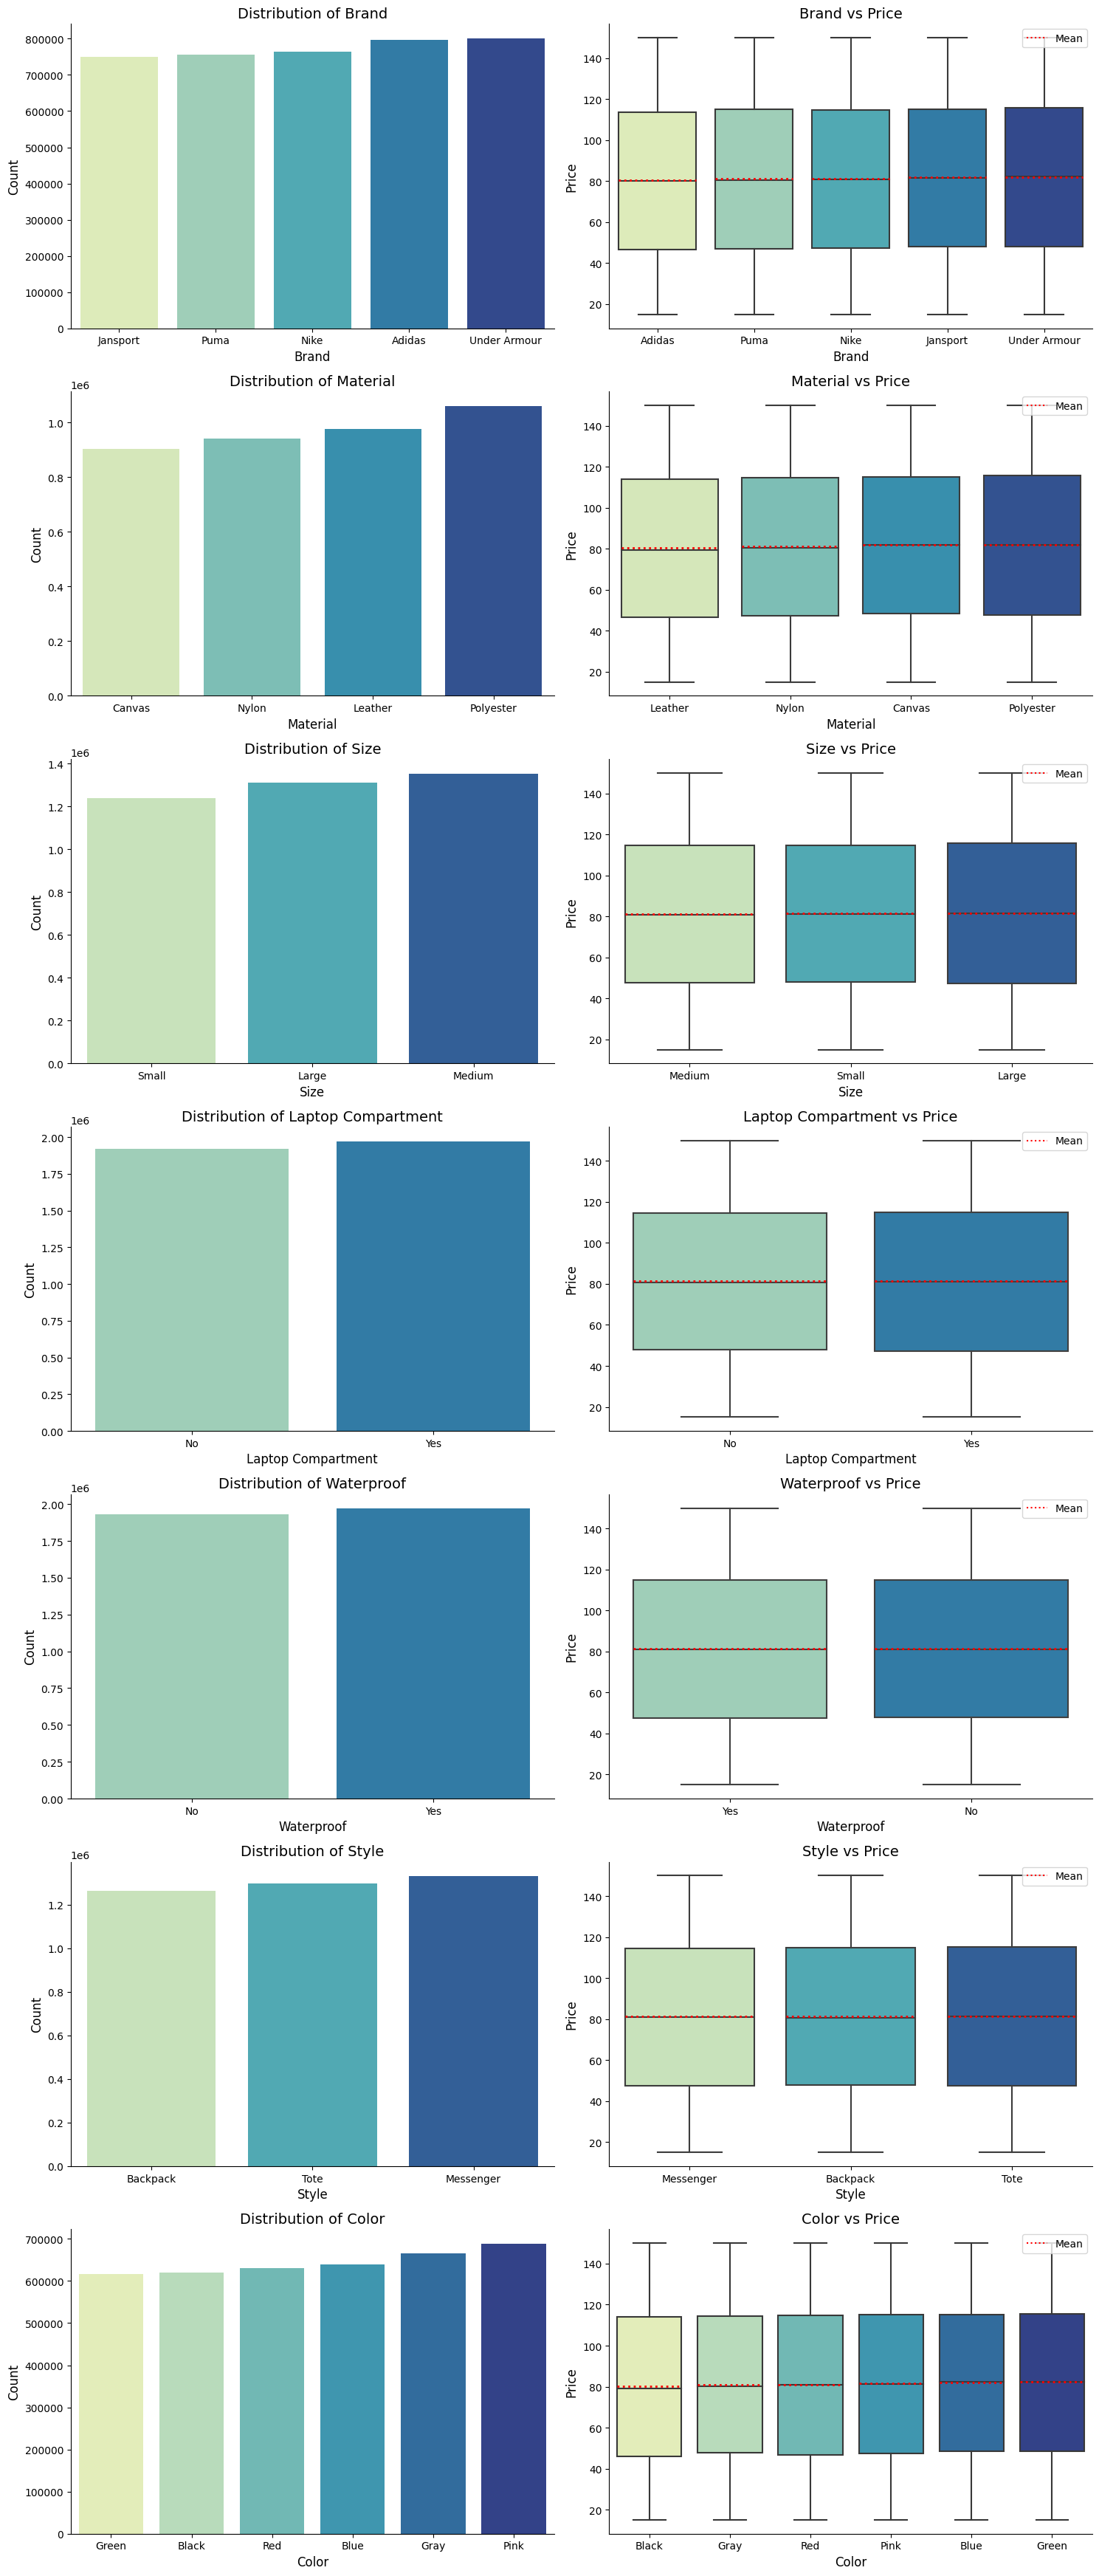

In [15]:
filtered_columns = [col for col in categorical_columns]

fig, axes = plt.subplots(len(filtered_columns), 2, figsize=(15, 5 * len(filtered_columns)))

for i, column in enumerate(filtered_columns):
    # --------------------------------------------------
    # 1) Barplot (LEFT SUBPLOT), sorted by ascending count
    # --------------------------------------------------
    freq_order = (
        train_df[column]
        .value_counts()
        .sort_values(ascending=True)
        .index
    )

    sns.countplot(
        data=train_df,
        x=column,
        order=freq_order,
        ax=axes[i, 0],
        palette='YlGnBu'
    )
    axes[i, 0].set_title(f"Distribution of {column}", fontsize=14)
    axes[i, 0].set_xlabel(column, fontsize=12)
    axes[i, 0].set_ylabel("Count", fontsize=12)
    sns.despine(ax=axes[i, 0])

    # --------------------------------------------------
    # 2) Boxplot (RIGHT SUBPLOT), sorted by ascending mean
    # --------------------------------------------------
    mean_order = (
        train_df.groupby(column)[target_column]
        .mean()
        .sort_values()
        .index
    )

    box_ax = axes[i, 1]
    sns.boxplot(
        data=train_df,
        x=column,
        y=target_column,
        order=mean_order,
        ax=box_ax,
        palette='YlGnBu',
        showmeans=True,
        meanline=True,
        meanprops={
            "color": "red",
            "ls": ":",
            "lw": 2
        }
    )
    box_ax.set_title(f"{column} vs {target_column}", fontsize=14)
    box_ax.set_xlabel(column, fontsize=12)
    box_ax.set_ylabel(target_column, fontsize=12)
    sns.despine(ax=box_ax)

    # Create a custom legend entry for the mean line
    mean_line = mlines.Line2D([], [], color='red', linestyle=':', label='Mean')
    box_ax.legend(handles=[mean_line], loc="upper right")  # Position legend in top-right

plt.tight_layout()
plt.show()


 1. **Brand**
- All brands are **evenly represented**, with similar counts.  
- **No strong price differentiation**—boxplots show overlapping ranges, with mean prices aligned across brands.

 2. **Material**
- Polyester is the most common material, followed by Leather and Nylon.  
- **Leather appears slightly more expensive**, but overall, price variation remains limited.

 3. **Size**
- Small, Medium, and Large bags are **evenly distributed**.  
- **No major price distinction**—mean prices remain aligned.

 4. **Laptop Compartment**
- Bags with and without a laptop compartment appear **equally frequent**.  
- **Price impact is negligible**—both categories show similar distributions.

 5. **Waterproof Feature**
- Waterproof and non-waterproof bags are **almost evenly split**.  
- **Price impact is minimal**, as both categories have nearly identical distributions.

 6. **Style**
- Messenger bags are the most common, but all styles are **evenly spread**.  
- **No clear price differentiation**—mean prices are closely aligned.

 7. **Color**
- No color dominates, with relatively **even distribution** across options.  
- **Color has no significant impact on price**, as all price distributions appear similar.

 **Key Takeaways**
- **Brand, Material, and Style** show minor variations in price, but **no major impact** is observed.  
- **Functional attributes (Laptop Compartment, Waterproofing, Size, and Color) do not influence pricing significantly**.  
- **Price variations likely stem from other attributes (e.g., design, branding strategy, or hidden features not in the dataset).**


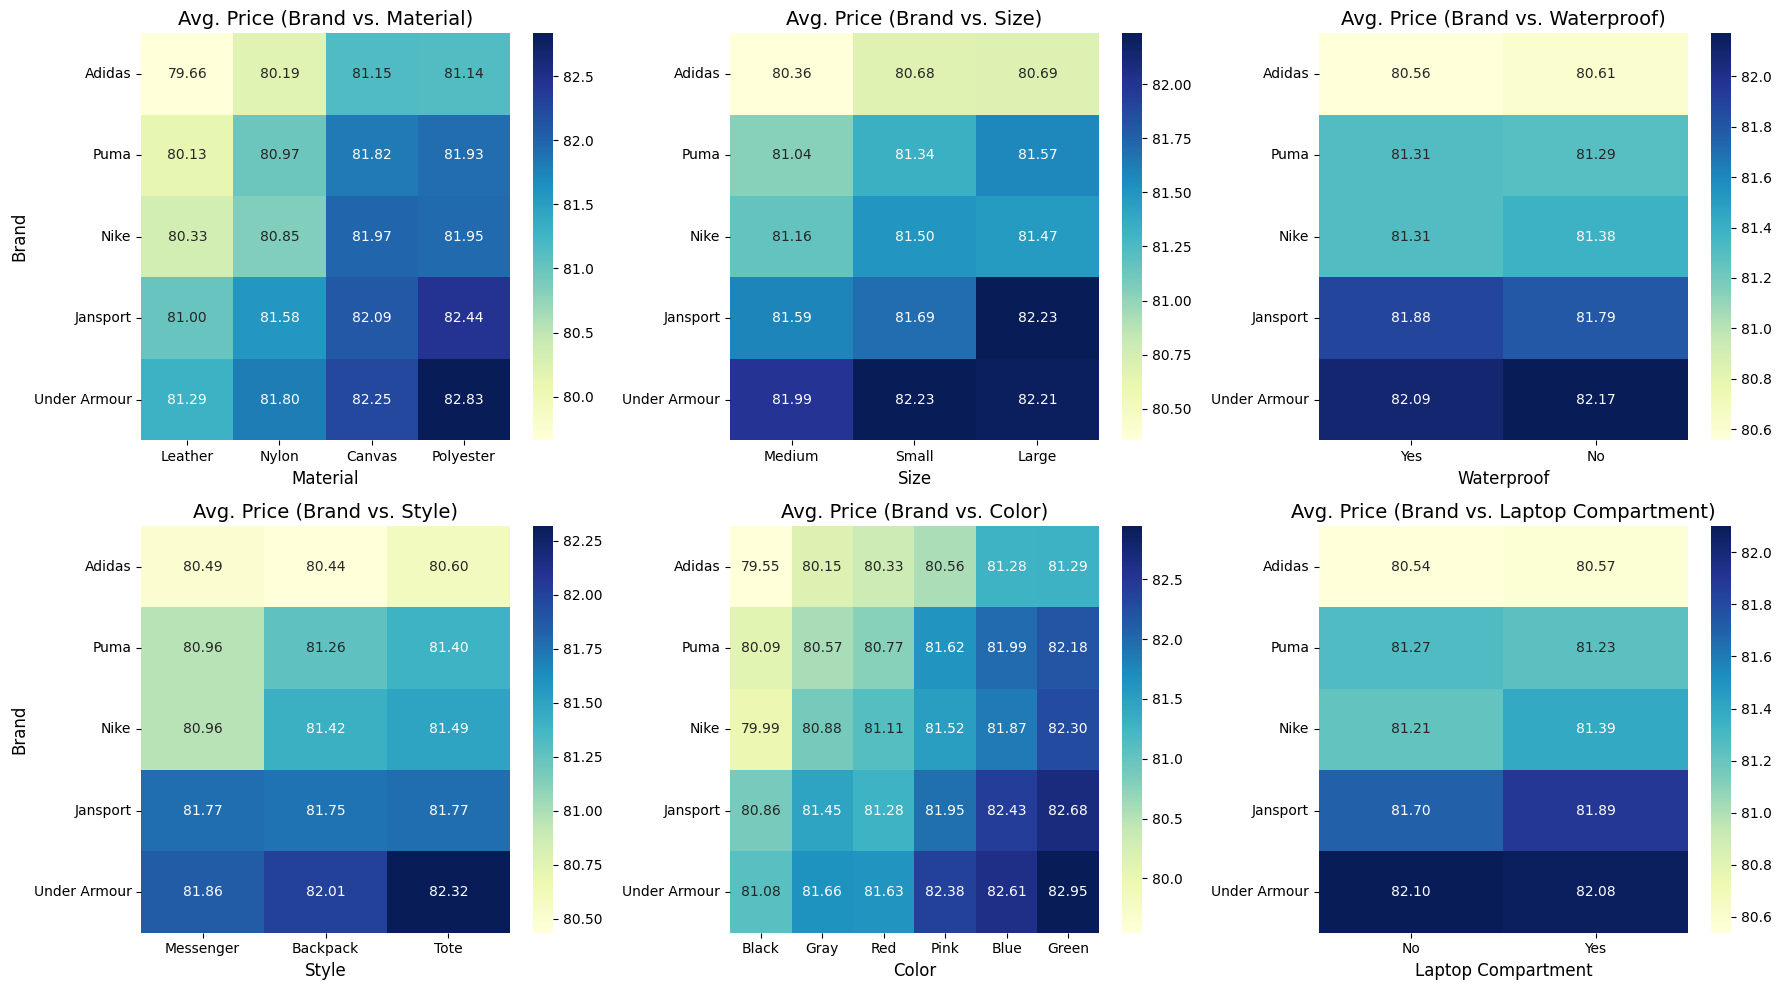

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------------------
# 1) Define the features for looping
# ---------------------------------------
features = ["Material", "Size", "Waterproof", "Style", "Color", "Laptop Compartment"]

# ---------------------------------------
# 2) Sort Brand by Overall Average Price
# ---------------------------------------
brand_order = (
    train_df
    .groupby("Brand")["Price"]
    .mean()
    .sort_values(ascending=True)
    .index
)

# Sort each categorical feature by average price
feature_orders = {}
for feat in features:
    feat_order = (
        train_df
        .groupby(feat)["Price"]
        .mean()
        .sort_values(ascending=True)
        .index
    )
    feature_orders[feat] = feat_order

# ---------------------------------------
# 3) Create Pivot Tables in a Loop
# ---------------------------------------
pivot_tables = {}

for feat in features:
    df_grouped = (
        train_df
        .groupby(["Brand", feat], as_index=False)
        .agg({"Price": "mean"})
    )

    df_pivot = df_grouped.pivot(index="Brand", columns=feat, values="Price")

    # Reorder index and columns
    valid_brands = brand_order.intersection(df_pivot.index)
    df_pivot = df_pivot.loc[valid_brands]

    valid_feats = feature_orders[feat].intersection(df_pivot.columns)
    df_pivot = df_pivot.loc[:, valid_feats]

    pivot_tables[feat] = df_pivot

# ---------------------------------------
# 4) Plot All Heatmaps with Adapted Axes
# ---------------------------------------
n_feats = len(features)
cols = 3  # 3 columns for better spacing
rows = int(np.ceil(n_feats / cols))  # Dynamic row count
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6 * cols, 5 * rows))

for i, feat in enumerate(features):
    row, col = divmod(i, cols)  # Compute row & col index dynamically
    ax = axes[row, col] if rows > 1 else axes[col]  # Adjust in case of single row
    sns.heatmap(
        pivot_tables[feat],
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        ax=ax
    )
    
    ax.set_title(f"Avg. Price (Brand vs. {feat})", fontsize=14)
    ax.set_xlabel(feat, fontsize=12)
    
    # Only the first column will have a y-label (Brand names)
    if col == 0:
        ax.set_ylabel("Brand", fontsize=12)
    else:
        ax.set_ylabel("")

# Remove empty subplots if `n_feats` is not a multiple of `cols`
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


## Heatmap Insights: Brand vs. Features

1. **Brand vs. Material :**
- Under Armour and Jansport price Canvas and Polyester higher, while Leather is consistently the least expensive.
- Nylon holds a higher price point for Jansport compared to other brands.

2. **Brand vs. Size :**
- Larger bags are slightly more expensive for Under Armour and Jansport, but the price impact remains minimal.
- Adidas and Puma maintain uniform pricing across sizes, suggesting a standardized approach.

3. **Brand vs. Waterproof :**
- Waterproofing has **no meaningful impact** on price across brands.
- Some brands (Nike, Puma, Jansport) show minor price differences, but variations are marginal.

4. **Brand vs. Style :**
- Backpack prices are slightly higher than Tote and Messenger bags.
- Under Armour and Jansport show the highest differentiation across styles.

5. **Brand vs. Color :**
- Green and Blue are slightly more expensive, while Black, Gray, and Red tend to be priced lower.
- Adidas exhibits the smallest color-based variation, while Under Armour shows more price fluctuation.

6. **Brand vs. Laptop Compartment :**
- **Jansport and Under Armour price models with laptop compartments slightly higher**, while Adidas and Puma show negligible variation.
- This suggests some brands consider laptop compartments as a premium feature, while others standardize them.

**Key Takeaways :**
- **Material remains the most significant price differentiator**, especially for Jansport and Under Armour.
- **Style and Color show moderate but visible price variations**, depending on brand.
- **Size and Waterproofing have very limited impact on pricing**, reinforcing that these features are either standard or not valued differently.
- **Laptop compartments hold some influence**, but only for select brands like Jansport and Under Armour.


# Data Preprocessing and Feature Engineering

Data preprocessing and feature engineering are essential steps in any machine learning pipeline. They ensure that the data is clean, well-structured, and optimized for training a model. In this notebook, we will walk through the preprocessing steps that prepare our dataset for predictive modeling.

---

### Objectives

- 🔧 **Impute missing values** to ensure completeness of the dataset.
- 🧠 **Apply target encoding** to categorical features for better model performance.
- 🧑‍🔬 **Standardize numerical features** to bring consistency to our data.
- ⚡ **Prepare the data** for effective model training and prediction.

---

Let’s dive into the preprocessing pipeline! 🚀

1. **Imputation for Missing Values :**
   - **Categorical Features**: Missing categorical values are replaced with `"Missing"`, allowing us to keep the feature's integrity without losing rows of data.
   - **Numerical Features**: Missing numerical values are filled using the **median** to ensure robustness, especially in the presence of outliers.

2. **Target Encoding for Categorical Features :**
   Target encoding transforms categorical variables into numeric representations based on their relationship with the target variable (backpack price). This encoding allows the model to learn how categories influence the target more effectively than traditional methods.

   - **For the Train Dataset**: We compute the mean target (price) for each category in the feature combinations and encode it.
   - **For the Test Dataset**: We apply the same encoding transformation to ensure consistency, filling missing values with the global median to maintain uniformity.

3. **Standardizing Numerical Features :**
   - Standardization scales numerical features to have a mean of 0 and a standard deviation of 1. This ensures that features are on the same scale, allowing models to perform better, especially when using algorithms sensitive to feature scales.

4. **Output :**
   - The processed datasets, along with the target encodings and standardization, are returned, ready for machine learning model training.

---

By the end of this process, our dataset will be clean, transformed, and ready for model training to predict the **price of backpacks** based on various features!

Let's get started with the preprocessing pipeline! 🚀


In [17]:
# Copy DataFrame to avoid modifying the original
train_df_fe = train_df.copy()

In [18]:
combinations_list = [
    ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof'],
    ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Style'],
    ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Color'],
    ['Brand', 'Material', 'Size', 'Waterproof', 'Style'],
    ['Brand', 'Material', 'Size', 'Waterproof', 'Color'],
    ['Brand', 'Material', 'Size', 'Style', 'Color'],
    ['Brand', 'Material', 'Laptop Compartment', 'Waterproof', 'Style'],
    ['Brand', 'Material', 'Laptop Compartment', 'Waterproof', 'Color'],
    ['Brand', 'Material', 'Laptop Compartment', 'Style', 'Color'],
    ['Brand', 'Material', 'Waterproof', 'Style', 'Color'],
    ['Brand', 'Size', 'Laptop Compartment', 'Waterproof', 'Style'],
    ['Brand', 'Size', 'Laptop Compartment', 'Waterproof', 'Color'],
    ['Brand', 'Size', 'Laptop Compartment', 'Style', 'Color'],
    ['Brand', 'Size', 'Waterproof', 'Style', 'Color'],
    ['Brand', 'Laptop Compartment', 'Waterproof', 'Style', 'Color'],
    ['Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style'],
    ['Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Color'],
    ['Material', 'Size', 'Laptop Compartment', 'Style', 'Color'],
    ['Material', 'Size', 'Waterproof', 'Style', 'Color'],
    ['Material', 'Laptop Compartment', 'Waterproof', 'Style', 'Color'],
    ['Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
]

In [19]:
# Function to apply target encoding for a single combination of features
def target_encoding_for_combination(train_df, col_name, target_col):
    """Calculates target encoding for a single combination of features."""
    # Convert list to string for column name and join features
    col_name_str = '_'.join(col_name)  # Convert list of features to a string
    features = col_name
    temp_col = train_df[features].astype(str).agg('_'.join, axis=1)

    # Add the target encoding column (initialized with NaN)
    train_df[f'{col_name_str}_target'] = np.nan

    # Compute mean target value for each category
    mean_map = train_df.groupby(temp_col)[target_col].mean()

    # Map computed means to the dataframe
    train_df[f'{col_name_str}_target'] = temp_col.map(mean_map)

    # Replace NaNs with the global median
    train_df[f'{col_name_str}_target'] = train_df[f'{col_name_str}_target'].fillna(train_df[f'{col_name_str}_target'].median())

    return col_name_str, mean_map

# Function to apply target encoding for all combinations
def apply_target_encoding(train_df, combinations_list, target_col):
    """Applies target encoding directly with the provided combinations."""
    target_encodings = {}

    # Sequentially apply target encoding for each combination in the list
    for col_name in combinations_list:
        col_name_str = '_'.join(col_name)  # Convert list to string for column name
        features = col_name
        temp_col = train_df[features].astype(str).agg('_'.join, axis=1)

        # Add the target encoding column (initialized with NaN)
        train_df[f'{col_name_str}_target'] = np.nan

        # Compute mean target value for each category
        mean_map = train_df.groupby(temp_col)[target_col].mean()

        # Map computed means to the dataframe
        train_df[f'{col_name_str}_target'] = temp_col.map(mean_map)

        # Replace NaNs with the global median
        train_df[f'{col_name_str}_target'] = train_df[f'{col_name_str}_target'].fillna(train_df[f'{col_name_str}_target'].median())

        # Save encoding map for test set
        target_encodings[col_name_str] = mean_map.to_dict()

    print(f"✅ Target Encoding Completed: {len(target_encodings)} Encoded Features")
    return train_df, target_encodings


def preprocess_dataset(train_df, test_df, target_col):
    """Preprocess the train and test datasets by applying feature engineering steps."""
    
    # -------------------------------
    # Step 1: Imputation for Missing Values
    # -------------------------------
    
    # Identify categorical and numerical features
    categorical_features = train_df.select_dtypes(include=['object']).columns
    numerical_features = ['Weight Capacity (kg)', 'Compartments']  # Assuming these are numerical features

    # Impute missing values for categorical columns with "Missing"
    train_df[categorical_features] = train_df[categorical_features].fillna("Missing")
    test_df[categorical_features] = test_df[categorical_features].fillna("Missing")

    # Impute missing values for numerical columns with median
    imputer = SimpleImputer(strategy='median')
    train_df[numerical_features] = imputer.fit_transform(train_df[numerical_features])
    test_df[numerical_features] = imputer.transform(test_df[numerical_features])
    
    # -------------------------------
    # Step 2: Apply Target Encoding to the Train Dataset
    # -------------------------------
    train_df, target_encodings = apply_target_encoding(train_df, combinations_list, target_col)
    
    # -------------------------------
    # Step 3: Apply Target Encoding to the Test Dataset
    # -------------------------------
    
    def transform_test_df(test_df, target_encodings, combinations_list):
        """Applies the same target encoding transformation to the test dataset."""
        
        # Apply target encoding for each combination
        for col_name in combinations_list:
            col_name_str = '_'.join(col_name)  # Convert the list of features to a string

            if all(f in test_df.columns for f in col_name):  # Check if all features exist in test_df
                temp_col = test_df[col_name].astype(str).agg('_'.join, axis=1)
                test_df[f'{col_name_str}_target'] = temp_col.map(target_encodings[col_name_str])
            else:
                test_df[f'{col_name_str}_target'] = np.nan  # Handle missing combinations
    
            # Replace missing target encodings with the global median from the training set
            test_df[f'{col_name_str}_target'].fillna(train_df[f'{col_name_str}_target'].median(), inplace=True)
    
        return test_df
    
    # Apply target encoding to the test dataset
    test_df = transform_test_df(test_df, target_encodings, combinations_list)

    # -------------------------------
    # Step 4: Standardize Numerical Features
    # -------------------------------

    # Extract target variable and drop it from dataset
    y = train_df[target_col]
    train_df = train_df.drop(columns=[target_col])

    # Define numerical features after feature engineering (excluding target column)
    numerical_features = train_df.select_dtypes(exclude=['object']).columns

    # Initialize and apply StandardScaler for numerical features
    scaler = StandardScaler()
    train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
    test_df[numerical_features] = scaler.transform(test_df[numerical_features])

    train_df["Price"] = y  # Reassign target to the train dataset

    return train_df, test_df, y, scaler, target_encodings


# Apply the full preprocessing pipeline
train_df_fe, test_df_fe, y_train, scaler, target_encodings = preprocess_dataset(train_df_fe, test_df, target_column)

print("✅ Training and testing datasets successfully processed.")

✅ Target Encoding Completed: 21 Encoded Features
✅ Training and testing datasets successfully processed.


## Target Encoding Visualization

This code extracts the first combination of features from the `target_encodings` dictionary and visualizes its **target encoding values**.


**Objective :**
This visualization helps us understand how the target encoding values are distributed across the categories of the first feature combination.


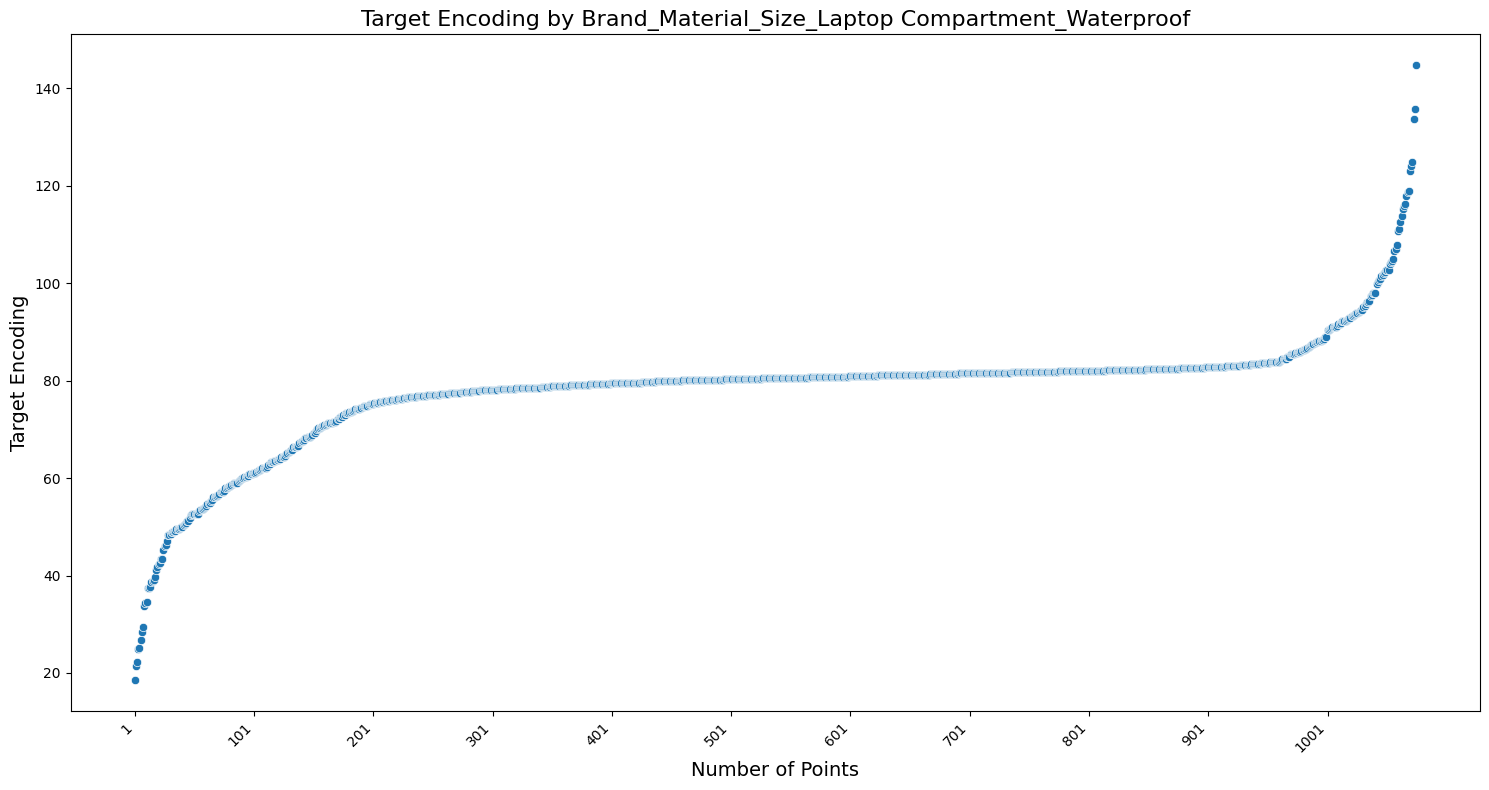

In [20]:
# Get the first combination from target_encodings
first_combination = list(target_encodings.keys())[0]

# Get the encoded values for the first combination
encoding_dict = target_encodings[first_combination]

# Create a dataframe with the interaction and target encoding values
encoding_df = pd.DataFrame(list(encoding_dict.items()), columns=['Interaction', 'Target Encoding'])

# Sort by target encoding value in ascending order
encoding_df = encoding_df.sort_values(by='Target Encoding', ascending=True)

# Plot the scatter plot with index on the x-axis
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=encoding_df,
    x=range(len(encoding_df)),  # Use the index as x-axis
    y='Target Encoding',
)

# Customize plot
plt.title(f"Target Encoding by {first_combination}", fontsize=16)
plt.xlabel('Number of Points', fontsize=14)  # Label for the x-axis
plt.ylabel('Target Encoding', fontsize=14)

# Display x-ticks only every 100 points
tick_step = 100
ticks = range(0, len(encoding_df), tick_step)
labels = [str(i + 1) for i in ticks]  # Generate labels as numbers from 1 to n
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")  # Show numbers on x-axis

plt.tight_layout()
plt.show()

# XGBoost Pipeline for Predicting Backpack Prices

In this notebook, we walk through a full **XGBoost pipeline** to predict the **price of backpacks** based on various features. The pipeline involves several important steps, including **hyperparameter tuning**, **model training**, and **prediction generation**. 

We aim to predict the **price** using both numerical and categorical features and achieve the best possible performance by optimizing hyperparameters and carefully evaluating the model.

---

### Objectives

- 🛠️ **Preprocess and prepare** the dataset for modeling.
- 🔍 **Tune hyperparameters** to improve model performance using **Optuna**.
- 🚀 **Train the model** using the best hyperparameters found during tuning.
- 📊 **Generate predictions** on the test set and **save** the submission.

---

1. **Hyperparameter Tuning with Optuna**

The first step in the pipeline is **hyperparameter tuning** using **Optuna**. Here, we use **Optuna**'s optimization capabilities to explore the best values for important hyperparameters of **XGBoost** like `max_depth`, `learning_rate`, `subsample`, and others. We perform this tuning on a **random sample** of the training data, utilizing **3-fold cross-validation** to evaluate the performance.

Key steps include:
- **Optuna optimization** to search for the optimal values for hyperparameters.
- **Cross-validation** to estimate the model's performance and avoid overfitting.
- **Tracking** of the best parameters and RMSE (Root Mean Squared Error) score for future use.

---

2. **Model Training**

Once the hyperparameters are optimized, we proceed to **train the final model** using **XGBoost** with the best parameters found. This model is trained on the full training dataset and evaluates its performance using **RMSE**. The model leverages **GPU acceleration** to speed up the training process with the `gpu_hist` method.

Key steps:
- **Training** the model using the best-found hyperparameters.
- **Early stopping** to prevent overfitting by monitoring the RMSE during training.
- **Saving the final model** for later prediction.

---

3. **Prediction and Submission**

After training the model, we generate predictions on the test dataset and prepare them for **Kaggle submission**. The predictions are saved into a CSV file with the format required by the competition.

Key steps:
- **Prediction** on the test set using the trained XGBoost model.
- **Saving** the predictions into a CSV file for submission.

---

**Pipeline Summary**

The pipeline runs the following steps:
1. **Hyperparameter Tuning**: Optimizing XGBoost's hyperparameters using Optuna.
2. **Training the Model**: Using the best parameters to train the final XGBoost model.
3. **Prediction**: Generating predictions on the test set.
4. **Submission**: Saving predictions for submission.

The entire pipeline ensures that the model is trained efficiently and optimized for predicting the **backpack prices**.

---

Let's run the pipeline and see how it performs! 🚀


In [21]:
class XGBPipeline:
    def __init__(self, train: pd.DataFrame, test: pd.DataFrame, test_ids: pd.Series,
                 target: str, features: list, cats: list,
                 te_params: dict = None,
                 sample_frac: float = 0.5,
                 random_state: int = 42):
        """
        Initializes the pipeline with training data, test data, target column, feature columns, categorical features, 
        and target encoding parameters.
        """
        self.train = train.copy()
        self.test = test.copy()
        self.test_ids = test_ids.copy()  # Safely store test IDs
        self.target = target
        self.features = features
        self.cats = cats
        self.sample_frac = sample_frac
        self.random_state = random_state

        # Default target encoder parameters
        if te_params is None:
            te_params = {'n_folds': 25, 'smooth': 20, 'split_method': 'random', 'stat': 'mean'}
        self.te_params = te_params
        self.TE = TargetEncoder(**self.te_params)
    
        self.best_params = None
        self.best_cv_rmse = None
        self.model_xgb = None
        self.model_lgbm = None
        self.model_lr = None
        self.stacking_model = None
        self.best_iteration = None
        self.all_features = self.features

    def hyperparameter_tuning(self, n_trials: int = 20):
        """
        Uses Optuna for hyperparameter tuning of XGBoost on a subsample of the training data.
        This step helps in finding the best hyperparameters for model training.
        """
        print("🔎 Starting hyperparameter tuning with Optuna...")
    
        # Convert categorical columns to 'category' for efficient handling in XGBoost
        self.train[self.cats] = self.train[self.cats].astype('category')
    
        # Check if features and target are correctly defined
        if not self.all_features or self.target not in self.train.columns:
            raise ValueError(f"❌ Features or target are incorrectly defined.\n"
                             f"self.all_features: {self.all_features}\n"
                             f"self.target: {self.target}")
    
        # Check for missing features in the training dataset
        missing_features = [col for col in self.all_features if col not in self.train.columns]
        if missing_features:
            raise ValueError(f"❌ Missing features in train dataset: {missing_features}")
    
        # Sample the training data for hyperparameter tuning
        train_sample = self.train.sample(frac=self.sample_frac, random_state=self.random_state)
    
        if train_sample.empty or self.target not in train_sample.columns:
            raise ValueError("❌ Train sample is empty or target column is missing.")
    
        def objective(trial):
            """
            Defines the objective function for Optuna to optimize the hyperparameters.
            We tune hyperparameters like max_depth, learning_rate, and others for better model performance.
            """
            params = {
                "max_depth": trial.suggest_int("max_depth", 4, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.05, log=True),
                "min_child_weight": trial.suggest_int("min_child_weight", 3, 10),
                "subsample": trial.suggest_float("subsample", 0.9, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.55, 0.65),
                "n_estimators": trial.suggest_int("n_estimators", 600, 1000),
                "reg_alpha": trial.suggest_float("reg_alpha", 0.95, 1.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.35, 0.45)
            }
    
            # Perform 3-fold cross-validation to evaluate the model
            cv = KFold(n_splits=3, shuffle=True, random_state=self.random_state)
            cv_scores = []
            for train_idx, val_idx in cv.split(train_sample):
                if train_sample.empty:
                    raise ValueError("❌ Train sample is empty during cross-validation.")
    
                X_train_cv = train_sample.iloc[train_idx][self.all_features]
                y_train_cv = train_sample.iloc[train_idx][self.target]
                X_val_cv = train_sample.iloc[val_idx][self.all_features]
                y_val_cv = train_sample.iloc[val_idx][self.target]
    
                model = XGBRegressor(
                    tree_method="gpu_hist",
                    enable_categorical=True,
                    random_state=self.random_state,
                    **params
                )
                model.fit(
                    X_train_cv, y_train_cv,
                    eval_set=[(X_val_cv, y_val_cv)],
                    eval_metric="rmse",
                    early_stopping_rounds=50,
                    verbose=False
                )
                preds = model.predict(X_val_cv)
                rmse = np.sqrt(mean_squared_error(y_val_cv, preds))
                cv_scores.append(rmse)
            return np.mean(cv_scores)
    
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials)
        self.best_params = study.best_trial.params
        self.best_cv_rmse = study.best_value
        print(f"✅ Best params: {self.best_params}")
        print(f"✅ Best CV RMSE: {self.best_cv_rmse}")

    def train_final_model(self):
        """
        Trains the final XGBoost model using the best hyperparameters obtained from Optuna.
        This is done on the full training dataset.
        """
        print("🚀 Training final XGBoost model...")
        self.model_xgb = XGBRegressor(
            tree_method="gpu_hist",
            enable_categorical=True,
            random_state=self.random_state,
            **self.best_params
        )
        self.model_xgb.fit(
            self.train[self.all_features], self.train[self.target],
            eval_metric="rmse",
            verbose=False
        )
        print("✅ Final model trained.")

    def predict_test(self):
        """
        Generates predictions on the test set using the trained XGBoost model.
        """
        print("📊 Generating test predictions...")
    
        # Ensure that categorical columns are encoded properly
        self.test[self.cats] = self.test[self.cats].astype('category')
    
        test_preds = self.model_xgb.predict(self.test[self.all_features])
        return test_preds

    def save_submission(self, predictions, filename="submission.csv"):
        """
        Saves the predictions to a CSV file for submission to Kaggle.
        """
        # Ensure test IDs are in a proper format
        sub = pd.DataFrame({"id": self.test_ids.values, self.target: predictions})
    
        # Ensure filename is a string
        if not isinstance(filename, str):
            raise TypeError("❌ `filename` must be a string.")
    
        # Save the submission file
        sub.to_csv(filename, index=False)
        print(f"✅ Submission saved to {filename}")

    def run_pipeline(self):
        """
        Runs the full pipeline: Preprocessing → Hyperparameter Tuning → Training → Prediction.
        """
        overall_start = time.time()
        
        # Define the steps of the pipeline
        steps = [
            ("Hyperparameter Tuning", self.hyperparameter_tuning),
            ("Training Final Model", self.train_final_model),
        ]
        
        # Run each step sequentially
        with tqdm(total=len(steps), desc="Pipeline Steps", unit="step") as pbar:
            print("🚀 Starting pipeline execution...")
            for step_name, step_func in steps:
                print(f"🔹 {step_name}...")
                step_func()  # Execute the function
                pbar.update(1)
                print(f"✅ Completed: {step_name}")
    
        print("📊 Predicting Test Set...")
        predictions = self.predict_test()
    
        print("💾 Saving Submission...")
        self.save_submission(predictions, filename="submission.csv")
    
        overall_elapsed = time.time() - overall_start
        print(f"🎯 Pipeline execution complete. Total time: {overall_elapsed:.2f} sec")


# 🚀 **Running the pipeline**

# Define necessary variables
target = "Price"
features = [col for col in train_df_fe.columns if col != target]
cats = train_df_fe.select_dtypes(include=['object', 'category']).columns.tolist()

# Initialize the pipeline and run
pipeline = XGBPipeline(train=train_df_fe, test=test_df_fe, test_ids=test_ids, 
                       target=target, features=features, cats=cats)

pipeline.run_pipeline()  # Run the complete pipeline

Pipeline Steps:   0%|          | 0/2 [00:00<?, ?step/s]

🚀 Starting pipeline execution...
🔹 Hyperparameter Tuning...
🔎 Starting hyperparameter tuning with Optuna...


[I 2025-02-08 00:06:22,556] A new study created in memory with name: no-name-db5b1991-e330-4fe0-a4d1-2ad73c98738f
[I 2025-02-08 00:06:50,483] Trial 0 finished with value: 38.84430667014831 and parameters: {'max_depth': 9, 'learning_rate': 0.04276069806757876, 'min_child_weight': 9, 'subsample': 0.9788610560190291, 'colsample_bytree': 0.6134355273494746, 'n_estimators': 692, 'reg_alpha': 0.9923716065684767, 'reg_lambda': 0.43946900906891034}. Best is trial 0 with value: 38.84430667014831.
[I 2025-02-08 00:07:22,252] Trial 1 finished with value: 38.831361791094814 and parameters: {'max_depth': 4, 'learning_rate': 0.048013974576909965, 'min_child_weight': 3, 'subsample': 0.9723204649392216, 'colsample_bytree': 0.5613567239481076, 'n_estimators': 710, 'reg_alpha': 0.95288758789492, 'reg_lambda': 0.42464467715530163}. Best is trial 1 with value: 38.831361791094814.
[I 2025-02-08 00:07:46,543] Trial 2 finished with value: 38.83412311899517 and parameters: {'max_depth': 6, 'learning_rate': 0.

✅ Best params: {'max_depth': 4, 'learning_rate': 0.02136418623859395, 'min_child_weight': 8, 'subsample': 0.9530213853988239, 'colsample_bytree': 0.5517276975975584, 'n_estimators': 853, 'reg_alpha': 0.9979878795502496, 'reg_lambda': 0.40720882255209473}
✅ Best CV RMSE: 38.83057537076527
✅ Completed: Hyperparameter Tuning
🔹 Training Final Model...
🚀 Training final XGBoost model...
✅ Final model trained.
✅ Completed: Training Final Model
📊 Predicting Test Set...
📊 Generating test predictions...
💾 Saving Submission...
✅ Submission saved to submission.csv
🎯 Pipeline execution complete. Total time: 714.94 sec


# XGBoost Pipeline Results

After running the full pipeline, we have successfully trained an XGBoost model and made predictions on the test set. Below is a summary of the key results:

---

**Best CV RMSE**:

The **best CV RMSE** obtained was **38.83**. This is the Root Mean Squared Error from the cross-validation, which measures the average prediction error of the model.

Given that the **mean price** of the backpacks is **81.36**, the RMSE of **38.83** indicates that on average, our model's predictions are off by **38.83** units.

---

**Evaluation**:

- The **RMSE of 38.83** is approximately **47.8%** of the mean price, meaning the model’s predictions are about **47.8%** off from the true values on average.
  
  \[
  \frac{38.83}{81.36} \times 100 = 47.8\%
  \]

- **What does this mean?**  
  An RMSE of **38.83** is a decent result for this type of regression task, but there’s still potential for improvement. Lower RMSE indicates a better fit, so exploring other models or improving feature engineering might help to reduce this further.

---

### **Next Steps**:

To improve the model further, you can consider the following:

- **Feature Engineering**: Introduce new features or combinations to capture more information about the dataset.
- **Model Exploration**: Experiment with **LightGBM** or **CatBoost**, which may offer better performance for this task.
- **Ensemble Models**: Use **stacking** or **bagging** techniques to combine different models and reduce bias.

---

In conclusion, this pipeline successfully trained a competitive model, but with further improvements, we can reduce the RMSE and get even better predictions.
